# Importing Necessary Libraries


In [1]:
import pandas as pd
from prophet import Prophet



c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


* Loading relevant Data into DataFrames

In [2]:
df_cpu=pd.read_csv('DatasetsForDemandForecasting/CPU_train.csv')
df_gpu=pd.read_csv('DatasetsForDemandForecasting/GPU_train.csv')
df_mobo=pd.read_csv('DatasetsForDemandForecasting/MOBO_train.csv')
df_ram=pd.read_csv('DatasetsForDemandForecasting/RAM_train.csv')  
df_psu=pd.read_csv('DatasetsForDemandForecasting/PSU_train.csv')
df_storage=pd.read_csv('DatasetsForDemandForecasting/Storage_train.csv')
df_case=pd.read_csv('DatasetsForDemandForecasting/Case_train.csv')    
'''7 types of Parts'''

'7 types of Parts'

# In the cell Below we 
1. Load a dataFrame with the dates for which we want to predict demand
2. Also load a holidays DataFrame to handle seasonality 
3. Define function to create model and store result of predictions 
4. Call the defined function 

In [3]:


# DataFrame containing future dates for prediction
df_future_dates = pd.read_csv('DatasetsForDemandForecasting/test_dates.csv')
predictions_by_product = {}
holidays_df = pd.read_csv('holidays.csv')
def fit_and_predict_by_product(df, future_dates=df_future_dates,holidays_funct=holidays_df):
    predictions_by_product = {}
    models_by_product = {}

    for product_id in df['Prod_id'].unique():
        df_product = df[df['Prod_id'] == product_id]

        # Create and fit a new Prophet model for each product
        prophet_model = Prophet(holidays=holidays_funct)
        prophet_model.fit(df_product[['ds', 'y']])
        models_by_product[product_id] = prophet_model
        # Make predictions for future dates
        future_df = future_dates
        predictions = prophet_model.predict(future_df)

        # Store the predictions in the dictionary
        predictions_by_product[product_id] = predictions[['ds', 'yhat']]

    return predictions_by_product,models_by_product

cpu_pred,cpu_model=fit_and_predict_by_product(df_cpu)
case_pred,case_model=fit_and_predict_by_product(df_case)
ram_pred,ram_model=fit_and_predict_by_product(df_ram)
storage_pred,storage_model=fit_and_predict_by_product(df_storage)
gpu_pred,gpu_model=fit_and_predict_by_product(df_gpu)
psu_pred,psu_model=fit_and_predict_by_product(df_psu)
mobo_pred,mobo_model=fit_and_predict_by_product(df_mobo)





09:15:34 - cmdstanpy - INFO - Chain [1] start processing
09:15:35 - cmdstanpy - INFO - Chain [1] done processing
09:15:35 - cmdstanpy - INFO - Chain [1] start processing
09:15:35 - cmdstanpy - INFO - Chain [1] done processing
09:15:35 - cmdstanpy - INFO - Chain [1] start processing
09:15:36 - cmdstanpy - INFO - Chain [1] done processing
09:15:36 - cmdstanpy - INFO - Chain [1] start processing
09:15:36 - cmdstanpy - INFO - Chain [1] done processing
09:15:36 - cmdstanpy - INFO - Chain [1] start processing
09:15:37 - cmdstanpy - INFO - Chain [1] done processing
09:15:37 - cmdstanpy - INFO - Chain [1] start processing
09:15:38 - cmdstanpy - INFO - Chain [1] done processing
09:15:38 - cmdstanpy - INFO - Chain [1] start processing
09:15:38 - cmdstanpy - INFO - Chain [1] done processing
09:15:38 - cmdstanpy - INFO - Chain [1] start processing
09:15:39 - cmdstanpy - INFO - Chain [1] done processing
09:15:39 - cmdstanpy - INFO - Chain [1] start processing
09:15:39 - cmdstanpy - INFO - Chain [1]

# As we have finished with model training and have stored the results of our prediction we now extract the results to a csv for future use 

In [4]:
def extract_to_csv(temp_dict,filename):
    output_directory = 'PredictionsBYProdId/'
    i=0
    result_dict={}
    for key, dataframe in temp_dict.items():
       
        dataframe['Prod_id']=key
        result_dict[key]=dataframe
    
    dfs_to_concat = [dataframe for dataframe in result_dict.values()]
    final_df = pd.concat(dfs_to_concat, ignore_index=True)
    final_df = final_df.set_index('Prod_id').reset_index()
    print('All Loops completed')
    final_df.to_csv('{}.csv'.format(filename),index=False)

extract_to_csv(cpu_pred,'CPU_pred')
extract_to_csv(case_pred,'Case_pred')
extract_to_csv(ram_pred,'RAM_pred')
extract_to_csv(storage_pred,'Storage_pred')
extract_to_csv(gpu_pred,"GPU_Pred")
extract_to_csv(psu_pred,'PSU_Pred')
extract_to_csv(mobo_pred,'MOBO_pred')

All Loops completed
All Loops completed
All Loops completed
All Loops completed
All Loops completed
All Loops completed
All Loops completed


# Evaluating Our Model By Calculating 
1. RMSE
2. MAE
3. MSE


In [38]:
from datetime import datetime
df_cpu_test=pd.read_csv('DatasetsForDemandForecasting/CPU_test.csv')
df_case_test=pd.read_csv('DatasetsForDemandForecasting/Case_test.csv')
df_gpu_test=pd.read_csv('DatasetsForDemandForecasting/GPU_test.csv')
df_mobo_test=pd.read_csv('DatasetsForDemandForecasting/MOBO_test.csv')
df_ram_test=pd.read_csv('DatasetsForDemandForecasting/RAM_test.csv')
df_storage_test=pd.read_csv('DatasetsForDemandForecasting/Storage_test.csv')
df_psu_test=pd.read_csv('DatasetsForDemandForecasting/PSU_test.csv')

def calculate_rmse(df_test, predictions_dict):
    rmse_arr = []
    mse_arr = []
    mae_arr = []

    for key, df_preds in predictions_dict.items():
        # Access the DataFrame for the current key
        df_test_product = df_test[df_test['Prod_id'] == key]

        # Filter predictions for dates up to December 2022
        df_preds = df_preds[df_preds['ds'] <= datetime(2022, 12, 1)]

        # Calculate absolute error
        abs_error = [abs(y_true - y_pred) for y_true, y_pred in zip(df_test_product['y'], df_preds['yhat'])]

        # Calculate squared error for MSE
        squared_error = [error ** 2 for error in abs_error]

        # Append errors to arrays
        mae_arr.append(sum(abs_error) / len(abs_error))
        mse_arr.append(sum(squared_error) / len(squared_error))
        rmse_arr.append((sum(squared_error) / len(squared_error)) ** 0.5)

    # Calculate overall metrics
    rmse = sum(rmse_arr) / len(rmse_arr)
    mse = sum(mse_arr) / len(mse_arr)
    mae = sum(mae_arr) / len(mae_arr)

    return rmse, mse, mae

rmse_cpu,mse_cpu,mae_cpu=calculate_rmse(df_cpu_test,cpu_pred)
rmse_case,mse_case,mae_case=calculate_rmse(df_case_test,case_pred)
rmse_gpu,mse_gpu,mae_gpu=calculate_rmse(df_gpu_test,gpu_pred)
rmse_mobo,mse_mobo,mae_mobo=calculate_rmse(df_mobo_test,mobo_pred)
rmse_ram,mse_ram,mae_ram=calculate_rmse(df_ram_test,ram_pred)
rmse_storage,mse_storage,mae_storage=calculate_rmse(df_storage_test,storage_pred)
rmse_psu,mse_psu,mae_psu=calculate_rmse(df_psu_test,psu_pred)
                       
        


C:\Users\Admin\AppData\Local\Temp\ipykernel_45608\734290220.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_actual_product['ds'] = pd.to_datetime(df_actual_product['ds'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_45608\734290220.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predicted_product['ds'] = pd.to_datetime(df_predicted_product['ds'])


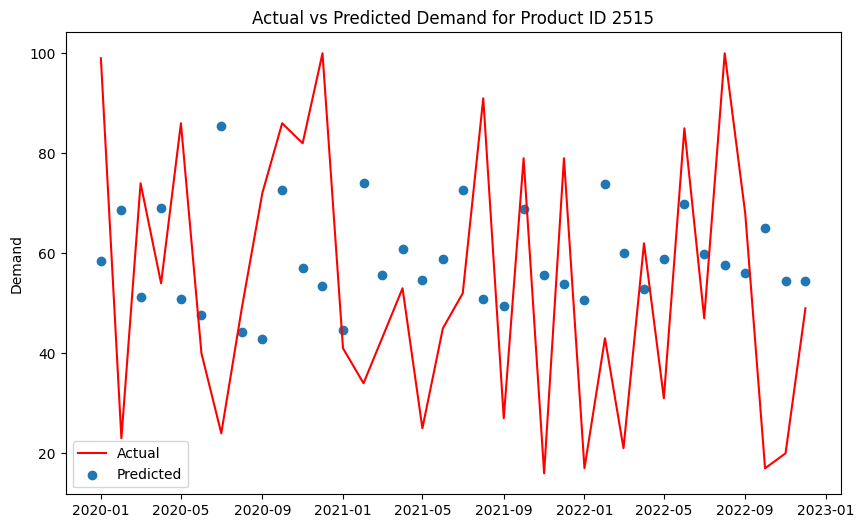

In [41]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_actual_vs_predicted(df_actual, df_predicted, product_id):
    # Filter actual and predicted dataframes for the specified product_id
    df_actual_product = df_actual[df_actual['Prod_id'] == product_id]
    df_predicted_product = df_predicted[df_predicted['Prod_id'] == product_id]

    # Ensure both dataframes have a 'ds' column
    if 'ds' not in df_actual_product.columns or 'ds' not in df_predicted_product.columns:
        print("Error: Both dataframes should have a 'ds' column.")
        return
    
    df_actual_product['ds'] = pd.to_datetime(df_actual_product['ds'])
    df_predicted_product['ds'] = pd.to_datetime(df_predicted_product['ds'])
    df_predicted_product = df_predicted_product[df_predicted_product['ds'] <= pd.to_datetime('2022-12-01')]
    # Plot the graph if there are data points to plot
    if not df_actual_product.empty and not df_predicted_product.empty:
        plt.figure(figsize=(10, 6))
        plt.plot(df_actual_product['ds'], df_actual_product['y'], label='Actual',color='red')
        plt.scatter(df_predicted_product['ds'], df_predicted_product['yhat'], label='Predicted')
        
        plt.ylabel('Demand')
        plt.title(f'Actual vs Predicted Demand for Product ID {product_id}')
        plt.legend()
        plt.show()
    else:
        print(f"No data available for Product ID {product_id} in the specified date range.")

cpu_pred_df=pd.read_csv("./Results/CPU_pred.csv")
plot_actual_vs_predicted(df_cpu_test,cpu_pred_df,2515)

In [42]:

print('For CPU RMSE:: {} MSE:: {} MAE:: {}'.format(rmse_cpu, mse_cpu, mae_cpu))
print('For Case RMSE:: {} MSE:: {} MAE:: {}'.format(rmse_case, mse_case, mae_case))
print('For GPU RMSE:: {} MSE:: {} MAE:: {}'.format(rmse_gpu, mse_gpu, mae_gpu))
print('For Motherboard RMSE:: {} MSE:: {} MAE:: {}'.format(rmse_mobo, mse_mobo, mae_mobo))
print('For RAM RMSE:: {} MSE:: {} MAE:: {}'.format(rmse_ram, mse_ram, mae_ram))
print('For Storage RMSE:: {} MSE:: {} MAE:: {}'.format(rmse_storage, mse_storage, mae_storage))
print('For PSU RMSE:: {} MSE:: {} MAE:: {}'.format(rmse_psu, mse_psu, mae_psu))


For CPU RMSE:: 29.23824725524628 MSE:: 864.2007341387676 MAE:: 24.58025512377866
For Case RMSE:: 29.461065246029435 MSE:: 876.9391249621877 MAE:: 24.819658901634142
For GPU RMSE:: 33.011859180560776 MSE:: 1101.7133961944346 MAE:: 27.262772639584995
For Motherboard RMSE:: 29.281390677485028 MSE:: 865.9539160324902 MAE:: 24.647924613521376
For RAM RMSE:: 29.343845472435035 MSE:: 869.7716399698895 MAE:: 24.71789195901871
For Storage RMSE:: 29.455046837977914 MSE:: 876.3308757981596 MAE:: 24.816357731239226
For PSU RMSE:: 29.32943380295348 MSE:: 869.100114149212 MAE:: 24.666094030884327
